In [1]:
import numpy as np
import scipy.sparse
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

default_cycler = (cycler(color=['#332288','#117733','#44AA99','#88CCEE','#CC6677','#AA4499','#882255']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams['text.usetex'] = True


def consistency(A1,B1,D1,A2,B2,D2):
    n1 = A1.shape[0]
    M1 = np.vstack([np.hstack([A1, B1.T]),
                    np.hstack([B1, D1])])
    M2 = np.vstack([np.hstack([D2, B2]),
                    np.hstack([B2.T, A2])])
    M = np.linalg.inv(M1)@M2.T
    #evals, evecs = scipy.sparse.linalg.eigs(M,k=n1+1,which='SM')
    evals, evecs = np.linalg.eig(M)
    idx = np.argsort(np.abs(evals))
    evals = evals[idx]
    evecs = evecs[:,idx]
    Y,X = evecs[:n1,:n1], evecs[n1:,:n1]
    L = np.linalg.solve(Y.T,X.T).T
    def LFT1(L):
        return -np.linalg.solve(A1+L.T@B1,B1.T+L.T@D1)
    def LFT2(G):
        return -np.linalg.solve(A2+G.T@B2,B2.T+G.T@D2)
    G = LFT1(L)  

    PSD1 = A1 + B1.T@L + L.T@B1 + L.T@D1@L
    PSD2 = A2 + B2.T@G + G.T@B2 + G.T@D2@G
    isCCVE = np.all(np.linalg.eigvals(PSD1)>0) and np.all(np.linalg.eigvals(PSD2)>0)

    G = LFT1(L)  

    error = ''
    
    if not isCCVE:
        error += 'second order conditions not PSD; '
        
    if not np.allclose(L,LFT2(G)):
        error += 'not a fixed point; '
    
    if np.isclose((evals[n1-1]),np.conj(evals[n1]),atol=1e-3):
        error += 'conjugate pair in the gap; '

    if np.isclose(np.abs(evals[n1-1]),np.abs(evals[n1]),atol=3e-3):
        error += 'not stable in policy space; '
    else:
        print('gap:',np.abs(evals[n1])-np.abs(evals[n1-1]))
        
    return (L,G,LFT1,LFT2),error

def solve1(L1,l1,A1,B1,D1,b1,d1):
    return -np.linalg.solve(A1 + L1.T@B1 + (B1.T + L1.T@D1)@L1, 
                            b1 + L1.T@d1 + (B1.T + L1.T@D1)@l1)

def solve2(L2,l2,A2,B2,D2,b2,d2):
    return -np.linalg.solve(A2 + L2.T@B2 + (B2.T + L2.T@D2)@L2,
                            b2 + L2.T@d2 + (B2.T + L2.T@D2)@l2)

def solve_eq(L, G, A1, B1, D1, b1, d1, A2, B2, D2, b2, d2):
    n1 = A1.shape[0]
    EQ = -np.linalg.solve(np.vstack([np.hstack([A1+L.T@B1,B1.T+L.T@D1]),
                                     np.hstack([B2.T+G.T@D2,A2+G.T@B2])]),
                          np.hstack([b1 + L.T@d1,
                                     b2 + G.T@d2]))
    return EQ[:n1], EQ[n1:]

In [2]:
seed = 1
np.random.seed(seed)
A1 = np.eye(2)
B1 = np.round(np.random.rand(3,2),1)-1/2
D1 = -0.2*np.eye(3)
b1 = np.zeros(2)
d1 = np.zeros(3)

A2 = np.eye(3)
B2 = -np.round(np.random.rand(2,3),1)+1/2
D2 = -0.1*np.eye(2)

b2 = np.ones(3)
d2 = np.ones(2)

n1 = 2
n2 = 3
print("seed:", seed)
(L,G,LFT1,LFT2),error=consistency(A1,B1,D1,A2,B2,D2)
if error:
    print(error)
    
assert np.allclose(L,LFT2(G)) and np.allclose(G, LFT1(L))
LFT = lambda L: LFT2(LFT1(L))

Lopt = np.copy(L)
CCVE = solve_eq(L,G,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
NE = solve_eq(np.zeros((n2,n1)),np.zeros((n1,n2)),A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)

ccve1,ccve2 = CCVE


def sim(x0,L0,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2):
    K = 40
    lr1,lr2 = 0.1,0.1
    n1 = A1.shape[0]
    n2 = A2.shape[0]
    x1 = np.zeros((K,n1))
    x2 = np.zeros((K,n2))
    x1guess = np.zeros((K,n1))
    x2guess = np.zeros((K,n2))
    L1 = np.zeros((K+1,n2,n1))
    L2 = np.zeros((K+1,n1,n2))
    l1 = np.zeros((K+1,n2))
    l2 = np.zeros((K+1,n1))
    
    l2[0] = NE[0] 
    l1[0] = NE[1] 
    
    x1[0],x2[0] = x0
    L1[0],L2[0] = L0

    for k in range(K):
        x1[k] = -np.linalg.solve(A1 + L1[k].T@B1 + (B1.T + L1[k].T@D1)@L1[k], 
                                 b1 + L1[k].T@d1 + (B1.T + L1[k].T@D1)@l1[k])
        x2[k] = -np.linalg.solve(A2 + L2[k].T@B2 + (B2.T + L2[k].T@D2)@L2[k],
                                 b2 + L2[k].T@d2 + (B2.T + L2[k].T@D2)@l2[k])
        
        x1guess[k] = L2[k]@x2[k]+l2[k]
        x2guess[k] = L1[k]@x1[k]+l1[k]

        L1[k+1] = -np.linalg.solve(A2 + L2[k].T@B2, B2.T + L2[k].T@D2)
        l1[k+1] = -np.linalg.solve(A2 + L2[k].T@B2, b2   + L2[k].T@d2)

        L2[k+1] = -np.linalg.solve(A1 + L1[k].T@B1, B1.T + L1[k].T@D1)
        l2[k+1] = -np.linalg.solve(A1 + L1[k].T@B1, b1   + L1[k].T@d1)

    return (x1,x2,L1,L2,x1guess,x2guess)

x0 = (np.zeros(n1),np.zeros(n2))
L0 = (np.zeros((n2,n1)),np.zeros((n1,n2)))
x1,x2,L1,L2,x1guess,x2guess = sim(x0,L0,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)

if np.all(np.abs(x1)<10) and np.all(np.abs(x2)<10):
    print('well behaved')
    print(A1)
    print(B1)
    print(D1)
    print(b1,d1)

    print(A2)
    print(B2.T)
    print(D2)
    print(b2,d2)
    
PSD1 = A1 + B1.T@L + L.T@B1 + L.T@D1@L
PSD2 = A2 + B2.T@G + G.T@B2 + G.T@D2@G
print("2nd order eigs", np.linalg.eigvals(PSD1), np.linalg.eigvals(PSD2))


seed: 1
gap: 1.0329744905725278
well behaved
[[1. 0.]
 [0. 1.]]
[[-0.1  0.2]
 [-0.5 -0.2]
 [-0.4 -0.4]]
[[-0.2 -0.  -0. ]
 [-0.  -0.2 -0. ]
 [-0.  -0.  -0.2]]
[0. 0.] [0. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.3  0. ]
 [ 0.2  0.1]
 [ 0.1 -0.2]]
[[-0.1 -0. ]
 [-0.  -0.1]]
[1. 1. 1.] [1. 1.]
2nd order eigs [1.18696432 0.7300497 ] [1.31850837 1.00002995 0.70967052]


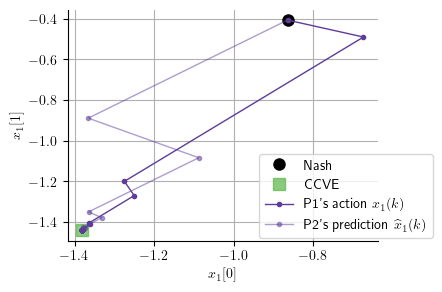

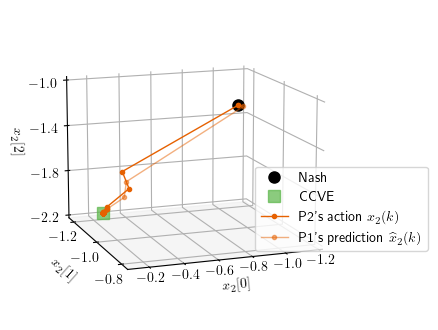

In [3]:

FIGSIZE = np.array([4]*2)

COLORX = '#5e3c99'
COLORY = '#e66101'
COLORC = '#5ab548'#'#44AA99'#"#d01c8b"
COLORN = 'black'
ms = 8
MS = 20

# ACTION PLOT x1
fig,ax = plt.subplots(figsize=FIGSIZE*np.array([1,0.75]))

ax.plot(*NE[0],'o',ms=ms,color=COLORN,label='Nash')
ax.plot(*CCVE[0],'s',ms=ms,color=COLORC,label='CCVE',zorder=3,alpha=0.7)
ax.plot(*x1[:-1].T,'.-',color=COLORX,zorder=10,label='P1\'s action $x_1(k)$')
ax.plot(*x1guess.T,'.-',color=COLORX,alpha=0.5,zorder=10,label='P2\'s prediction $\\widehat{x}_1(k)$')
ax.set_xlabel(xlabel='$x_{1}[0]$')
ax.set_ylabel(ylabel='$x_{1}[1]$')

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.2, -0.02))
ax.grid()

fig.savefig('2023lcss-2x3-phase-x1.pdf',bbox_inches='tight')

# ACTION PLOT x2
fig = plt.figure(figsize=FIGSIZE*np.array([1,1.5]))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot(*NE[1],'o',ms=ms,color=COLORN,label='Nash')
ax.plot(*CCVE[1],'s',ms=ms,color=COLORC,alpha=0.7,label='CCVE')
ax.plot(*x2.T,'.-',color=COLORY,label='P2\'s action $x_2(k)$')
ax.plot(*x2guess.T,'.-',color=COLORY,alpha=0.5,zorder=10,label='P1\'s prediction $\\widehat{x}_2(k)$')
ax.set_xlabel(xlabel='$x_2[0]$', rotation=0, labelpad=-6)
ax.set_ylabel(ylabel='$x_2[1]$', rotation=0, labelpad=-1)
ax.set_zlabel(zlabel='$x_2[2]$', rotation=0, labelpad=4)
ax.legend()
ax.legend(loc=4,bbox_to_anchor=(1.3, 0.2))
ax.set(zticks=np.linspace(-2.2,-1.0,4))
ax.set(xticks=np.linspace(-0.2,-1.2,6),xlim=[-1.2,-0.1])
ax.set(yticks=np.linspace(-0.8,-1.2,3))

elev = 13
azim = 70
roll = 'z'
ax.view_init(elev, azim, roll)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.tick_params(axis='x', which='major', pad=-5)
ax.tick_params(axis='y', which='major', pad=-1)

fig.savefig('2023lcss-2x3-phase-x2.pdf',bbox_inches='tight')

In [4]:
opt1 = np.linalg.solve(-np.vstack([np.hstack([A1, B1.T]),
                                   np.hstack([B1, D1])]),
                        np.hstack([b1,d1]))

opt2 = np.linalg.solve(-np.vstack([np.hstack([D2,   B2]),
                                   np.hstack([B2.T, A2])]),
                        np.hstack([d2,b2]))

M = np.vstack([np.hstack([A1, B1.T]), np.hstack([B1, D1])])+\
np.vstack([np.hstack([D2, B2]),  np.hstack([B2.T, A2])])
np.linalg.eigvals(M)

opt_social = np.linalg.solve(-M, np.hstack([b1,d1])+np.hstack([d2,b2]))

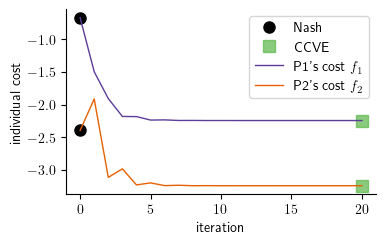

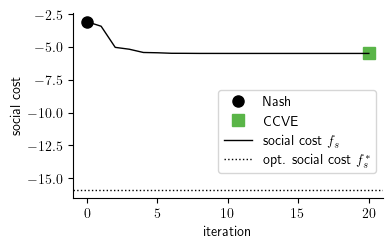

In [5]:
def f1(x1,x2):
    return 1/2*x1.T@A1@x1 + x2.T@B1@x1 + 1/2*x2.T@D1@x2 + b1@x1 + d1@x2 

def f2(x1,x2):
    return 1/2*x2.T@A2@x2 + x1.T@B2@x2 + 1/2*x1.T@D2@x1 + b2@x2 + d2@x1 

def f(x):
    _1,_2 = x[:n1],x[n1:]
    return f1(_1,_2)+f2(_1,_2)

TOTAL = 21
fig1,ax1 = plt.subplots(figsize=(4,2.4))
fig2,ax2 = plt.subplots(figsize=(4,2.4))
cost1 = [f1(_1,_2) for _1,_2 in zip(x1,x2)]
cost2 = [f2(_1,_2) for _1,_2 in zip(x1,x2)]
ax1.plot(0,f1(NE[0],NE[1]),'ok',ms=ms,label='Nash')
ax1.plot(0,f2(NE[0],NE[1]),'ok',ms=ms)
ax1.plot(TOTAL-1,f1(CCVE[0],CCVE[1]),'s',color=COLORC,alpha=0.7,ms=ms,label='CCVE')
ax1.plot(TOTAL-1,f2(CCVE[0],CCVE[1]),'s',color=COLORC,alpha=0.7,ms=ms)
ax1.plot(cost1[:TOTAL],color=COLORX,label='P1\'s cost $f_1$')# $f_1(x_1(k),x_2(k))$')
ax1.plot(cost2[:TOTAL],color=COLORY,label='P2\'s cost $f_2$')# $f_2(x_1(k),x_2(k))$')
ax1.set(xlabel='iteration')
ax1.set(ylabel='individual cost')
ax1.legend(loc='upper right')
ax1.spines.top.set_visible(False)
ax1.spines.right.set_visible(False)

fig1.savefig('2023lcss-2x3-cost-individual.pdf',bbox_inches='tight')
total_cost = (np.array(cost1)+np.array(cost2))
ax2.plot(0,total_cost[0],'o',color='k',ms=ms,label='Nash')
ax2.plot(TOTAL-1,total_cost[TOTAL],'s',color=COLORC,ms=ms,label='CCVE')
ax2.plot(total_cost[:TOTAL],'k',label='social cost $f_s$')
ax2.axhline(f(opt_social),ls=':',color='k',label='opt. social cost $f_s^*$')
ax2.set(xlabel='iteration')
ax2.set(ylabel='social cost')
ax2.legend(loc='lower right',bbox_to_anchor=(1,0.1))
ax2.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)

fig2.savefig('2023lcss-2x3-cost-total.pdf',bbox_inches='tight')


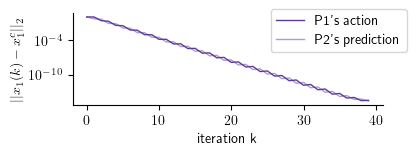

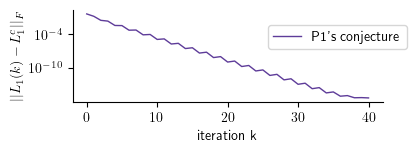

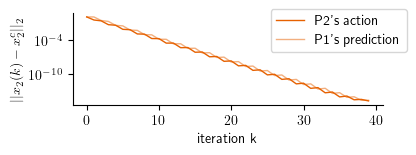

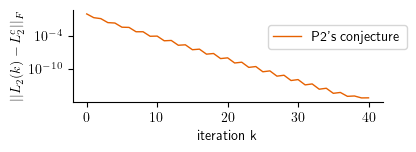

In [6]:
FIGSIZE = (4,1.2)
fig,ax = plt.subplots(figsize=FIGSIZE)
ax.plot(np.linalg.norm(x1-CCVE[0],axis=1),color=COLORX,label='P1\'s action')#$||x_1(k) - x_1^c||_2$')
ax.plot(np.linalg.norm(x1guess-CCVE[0],axis=1),color=COLORX,alpha=0.5,label='P2\'s prediction')#$||\\widehat{x}_1(k) - x_1^c||_2$')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.1,0.5))
ax.set(xlabel='iteration k')
ax.set(ylabel='$||x_1(k) - x_1^c||_2$')
ax.set_yscale('log')
fig.savefig('2023lcss-2x3-norm-x1.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=FIGSIZE)
ax.plot(range(len(L1)),np.linalg.norm((L1-L).reshape(-1,n1*n2),axis=1),color=COLORX,label='P1\'s conjecture')#$||L_1(k) - L_1^c||_F$',ls='-')#,where='post')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.1,0.5))
ax.set(xlabel='iteration k')
ax.set(ylabel='$||L_1(k) - L_1^c||_F$')
ax.set_yscale('log')
fig.savefig('2023lcss-2x3-norm-L1.pdf',bbox_inches='tight')


fig,ax = plt.subplots(figsize=FIGSIZE)
ax.plot(np.linalg.norm(x2-CCVE[1],axis=1),color=COLORY,label='P2\'s action')#$||x_2(k)-x_2^c||_2$')
ax.plot(np.linalg.norm(x2guess-CCVE[1],axis=1),color=COLORY,alpha=0.5,label='P1\'s prediction')#$||\\widehat{x}_2(k)-x_2^c||_2$')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.1,0.5))
ax.set(xlabel='iteration k')
ax.set(ylabel='$||x_2(k)-x_2^c||_2$')
ax.set_yscale('log')
fig.savefig('2023lcss-2x3-norm-x2.pdf',bbox_inches='tight')


fig,ax = plt.subplots(figsize=FIGSIZE)
ax.plot(range(len(L2)),np.linalg.norm((L2-G).reshape(-1,n1*n2),axis=1),color=COLORY,ls='-',label='P2\'s conjecture')#$||L_2(k)-L_2^c||_F$')#,where='post')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.1,0.5))
ax.set(xlabel='iteration k')
ax.set(ylabel='$||L_2(k) - L_2^c||_F$')
ax.set_yscale('log')
fig.savefig('2023lcss-2x3-norm-L2.pdf',bbox_inches='tight')


In [7]:
data_eq = []
data_iter = []
count = 0
for seed in range(1,100):
    n1 = 50
    n2 = 60

    np.random.seed(seed)
    A1 = 13*np.eye(n1)
    B1 = np.random.rand(n2,n1)*2-1

    D1 = -.2*np.eye(n2)
    b1 = np.zeros(n1)
    d1 = np.zeros(n2)

    A2 = 13*np.eye(n2)
    B2 = np.random.rand(n1,n2)*2-1

    D2 = -.1*np.eye(n1)
    
    b2 = np.ones(n2)
    d2 = np.ones(n1)
    print('count:', seed)
    (L,G,LFT1,LFT2),error=consistency(A1,B1,D1,A2,B2,D2)
    if error:
        print('ERROR:',error)
        continue
    LFT = lambda L: LFT2(LFT1(L))
    L,G
    CCVE = solve_eq(L,G,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
    NE = solve_eq(np.zeros((n2,n1)),np.zeros((n1,n2)),A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
    
    T = 30
    L_ = np.zeros((T,*L.shape))
    L_[0] = np.real(L)+.01*np.random.randn(*L.shape)
    for t in range(T-1):
        L_[t+1] = LFT(L_[t])

    data_eq.append([L,G])
    data_iter.append([L_,[LFT1(_) for _ in L_]])
    
    
    count += 1
    if count >= 5:
        break
        
norm1 = []
norm2 = []
for eq,data in zip(data_eq,data_iter):
    print("Processing...")
    L,G = eq
    L_,G_ = data
    norm1.append(np.linalg.norm(L_ - L,axis=(1,2)))
    norm2.append(np.linalg.norm(G_ - G,axis=(1,2)))
print("Done")


count: 1
gap: 0.8954064010831632
count: 2
gap: 1.5267059529350089
count: 3
gap: 1.4199664230758415
count: 4
gap: 0.8639796890434055
count: 5
gap: 1.2896473713593108
Processing...
Processing...
Processing...
Processing...
Processing...
Done


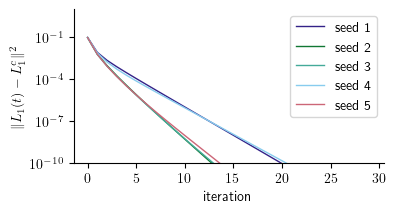

In [8]:
fig,ax = plt.subplots(figsize=(4,2))

for i,(n1,n2) in enumerate(zip(norm1,norm2)):
    ax.plot(n2,label="seed "+str(i+1))

ax.set_yscale('log')
ax.set(xlabel='iteration')
ax.set(ylabel='$\|L_1(t)-L_1^c\|^2$')

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.legend()
ax.set(ylim=[1e-10,1e1])
fig.savefig('2023lcss-202x303-norm.pdf',bbox_inches='tight')


# 